# Pràctica: Classificació de Jugadors FIFA 22

## 1. Objectius d'Aprenentatge
En aquesta pràctica aplicarem el flux de treball estàndard de la Ciència de Dades:
1.  **Càrrega i Neteja de dades:** Gestionar valors nuls, dades categòriques i renou.
2.  **Anàlisi Exploratòria (EDA):** Entendre les dades mitjançant visualitzacions.
3.  **Preprocessament:** Escalat i codificació.
4.  **Modelatge:** Entrenar classificadors lineals (**Regressió Logística**, **Perceptró**) i no lineals (**Random Forest**).
5.  **Avaluació:** Detectar *overfitting* i analitzar mètriques.

L'objectiu final és predir la **posició general** d'un jugador (Atacant, Migcampista, Defensor, Porter) basant-nos en les seves estadístiques físiques i tècniques.

[Enllaç al Dataset Original (Kaggle)](https://www.kaggle.com/datasets/bryanb/fifa-player-stats-database)

## 2. Carrega i exploració inicial

Per llegir les dades emprarem la llibreria de ``pandas``. El fitxer en qüestió és el fitxer que heu descarregat de Kaggle. I provam les eines de Pandas.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuració per veure totes les columnes
pd.set_option('display.max_columns', None)

# Llegim les dades
df = pd.read_csv("dades.csv")

print(f"Dimensions del dataset: {df.shape}")
df.head()

Dimensions del dataset: (16710, 65)


,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Best Position,Best Overall Rating,Release Clause,DefensiveAwareness
0,212198,Bruno Fernandes,26,https://cdn.sofifa.com/players/212/198/22_60.png,Portugal,https://cdn.sofifa.com/flags/pt.png,88,89,Manchester United,https://cdn.sofifa.com/teams/11/30.png,€107.5M,€250K,2341,Right,3.0,3.0,4.0,High/ High,Unique,Yes,"<span class=""pos pos18"">CAM",18.0,"Jan 30, 2020",NaN,2025,179cm,69kg,87.0,83.0,64.0,91.0,87.0,83.0,87.0,87.0,88.0,87.0,77.0,73.0,80.0,91.0,79.0,89.0,73.0,91.0,70.0,89.0,78.0,66.0,87.0,90.0,91.0,87.0,NaN,73.0,65.0,12.0,14.0,15.0,8.0,14.0,CAM,88.0,€206.9M,72.0
1,209658,L. Goretzka,26,https://cdn.sofifa.com/players/209/658/22_60.png,Germany,https://cdn.sofifa.com/flags/de.png,87,88,FC Bayern München,https://cdn.sofifa.com/teams/21/30.png,€93M,€140K,2314,Right,4.0,4.0,3.0,High/ Medium,Unique,Yes,"<span class=""pos pos11"">LDM",8.0,"Jul 1, 2018",NaN,2026,189cm,82kg,75.0,82.0,86.0,86.0,69.0,84.0,76.0,75.0,84.0,87.0,78.0,83.0,76.0,88.0,71.0,85.0,79.0,88.0,88.0,86.0,81.0,86.0,85.0,84.0,60.0,82.0,NaN,85.0,77.0,13.0,8.0,15.0,11.0,9.0,CM,87.0,€160.4M,74.0
2,176580,L. Suárez,34,https://cdn.sofifa.com/players/176/580/22_60.png,Uruguay,https://cdn.sofifa.com/flags/uy.png,88,88,Atlético de Madrid,https://cdn.sofifa.com/teams/240/30.png,€44.5M,€135K,2307,Right,5.0,4.0,3.0,High/ Medium,Unique,Yes,"<span class=""pos pos24"">RS",9.0,"Sep 25, 2020",NaN,2022,182cm,83kg,80.0,93.0,84.0,83.0,90.0,83.0,86.0,82.0,77.0,86.0,76.0,69.0,75.0,92.0,78.0,89.0,69.0,78.0,85.0,88.0,87.0,41.0,91.0,84.0,83.0,87.0,NaN,45.0,38.0,27.0,25.0,31.0,33.0,37.0,ST,88.0,€91.2M,42.0
3,192985,K. De Bruyne,30,https://cdn.sofifa.com/players/192/985/22_60.png,Belgium,https://cdn.sofifa.com/flags/be.png,91,91,Manchester City,https://cdn.sofifa.com/teams/10/30.png,€125.5M,€350K,2304,Right,4.0,5.0,4.0,High/ High,Unique,Yes,"<span class=""pos pos13"">RCM",17.0,"Aug 30, 2015",NaN,2025,181cm,70kg,94.0,82.0,55.0,94.0,82.0,88.0,85.0,83.0,93.0,91.0,76.0,76.0,79.0,91.0,78.0,91.0,63.0,89.0,74.0,91.0,76.0,66.0,88.0,94.0,83.0,89.0,NaN,65.0,53.0,15.0,13.0,5.0,10.0,13.0,CM,91.0,€232.2M,68.0
4,224334,M. Acuña,29,https://cdn.sofifa.com/players/224/334/22_60.png,Argentina,https://cdn.sofifa.com/flags/ar.png,84,84,Sevilla FC,https://cdn.sofifa.com/teams/481/30.png,€37M,€45K,2292,Left,2.0,3.0,4.0,High/ High,Stocky (170-185),No,"<span class=""pos pos7"">LB",19.0,"Sep 14, 2020",NaN,2024,172cm,69kg,87.0,66.0,58.0,82.0,68.0,87.0,88.0,75.0,78.0,88.0,77.0,76.0,83.0,83.0,90.0,82.0,63.0,90.0,80.0,81.0,84.0,79.0,81.0,82.0,76.0,87.0,NaN,84.0,82.0,8.0,14.0,13.0,13.0,14.0,LB,84.0,€77.7M,80.0


### 2.1 Selecció de característiques (Feature Selection)
El dataset té més de 60 columnes. Per a un modelatge eficient, sovint necessitem descartar informació irrellevant (com fotos, logos o IDs) o redundant.

Per a aquest exercici, ens quedarem amb un subconjunt d'atributs rellevants per a la posició.

In [2]:
# Eliminem columnes que no aporten informació esportiva per la predicció
cols_to_drop = ['ID', 'Name', 'Photo', 'Nationality', 'Flag', 'Club', 'Club Logo', 'Real Face', 'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until']
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# Veiem les columnes restants
print(df.columns.tolist())

['Age', 'Overall', 'Potential', 'Value', 'Wage', 'Special', 'Preferred Foot', 'International Reputation', 'Weak Foot', 'Skill Moves', 'Work Rate', 'Body Type', 'Position', 'Height', 'Weight', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes', 'Best Position', 'Best Overall Rating', 'Release Clause', 'DefensiveAwareness']


## 3. Neteja i Transformació de Dades (Data Cleaning)

### 3.1 Gestió de Valors Nuls (NaNs)
Tenim diverses estratègies. La presència de NaNs nos ens permet emprar les dades per fer prediccions. Disposam de quatre estratègies per resoldre aquest problema:

- **Eliminar les files amb NaNs**
- **Eliminar les columnes amb NaNs**
- **Substituir per un valor fixe**
- **Substituir per una mesura d'agregació**
  
Com que la `Position` és el nostre objectiu (target), si no en té, no podem entrenar. La resta, podem imputar-los.

In [3]:
# 1. Eliminem files on no tenim la variable objectiu 'Position' o 'Best Position'
df.dropna(subset=['Best Position'], inplace=True)

# 2. Per a la resta de columnes numèriques, omplim amb la mitjana (Imputació)
# Seleccionem només columnes numèriques per evitar errors
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

print(f"Nuls restants: {df.isna().sum().sum()}")

Nuls restants: 1804


### 3.2 Neteja de dades brutes (Strings amb unitats)
La columna `Value` i `Wage` contenen símbols com '€', 'K' (milers) i 'M' (milions). Els models matemàtics només entenen nombres.

In [ ]:
def value_to_float(x):
    """Converteix cadenes de text tipus '€1.5M' a floats."""
    if isinstance(x, (float, int)):
        return x
    
    x = x.replace('€', '')
    ret_val = 0.0
    
    if 'K' in x:
        ret_val = float(x.replace('K', '')) * 1000
    elif 'M' in x:
        ret_val = float(x.replace('M', '')) * 1000000
    else:
        try:
            ret_val = float(x)
        except:
            ret_val = 0.0
    return ret_val

df['Value'] = df['Value'].apply(value_to_float)
df['Wage'] = df['Wage'].apply(value_to_float)
df['Release Clause'] = df['Release Clause'].apply(value_to_float)

df[['Value', 'Wage']].head()

## 4. Enginyeria de Característiques (Feature Engineering)

### 4.1 Simplificació del Target
El dataset té moltes posicions específiques (CAM, RCM, LWB, etc.). Per facilitar l'aprenentatge del model en aquesta pràctica introductòria, agruparem les posicions en 4 grans blocs:
* **0: Attackers** (ST, CF, LW, RW)
* **1: Midfielders** (CM, CAM, CDM, LM, RM)
* **2: Defenders** (CB, LB, RB, LWB, RWB)
* **3: Goalkeepers** (GK)

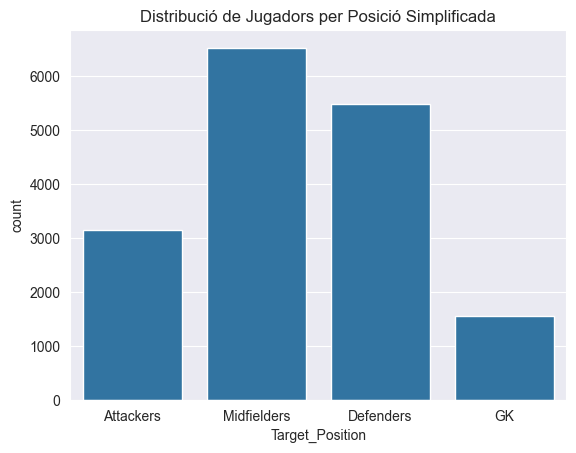

In [6]:
# Mapeig de posicions
position_map = {
    'ST': 0, 'CF': 0, 'LW': 0, 'RW': 0, 'LS': 0, 'RS': 0, 'LF': 0, 'RF': 0,
    'CAM': 1, 'CM': 1, 'CDM': 1, 'LM': 1, 'RM': 1, 'RCM': 1, 'LCM': 1, 'LDM': 1, 'RDM': 1,
    'CB': 2, 'LB': 2, 'RB': 2, 'LWB': 2, 'RWB': 2, 'LCB': 2, 'RCB': 2,
    'GK': 3
}

# Creem una nova columna numèrica pel target
df['Target_Position'] = df['Best Position'].map(position_map)

# Eliminem files on la posició no s'hagi pogut mapejar (per seguretat)
df.dropna(subset=['Target_Position'], inplace=True)

# Visualitzem el balanceig de classes
sns.countplot(x='Target_Position', data=df)
plt.title("Distribució de Jugadors per Posició Simplificada")
plt.xticks([0, 1, 2, 3], ['Attackers', 'Midfielders', 'Defenders', 'GK'])
plt.show()

> **Nota:** És important veure si les classes estan balancejades. Si tinguéssim molt pocs porters, el model podria tenir problemes per aprendre a identificar-los.

## 5. Correlació i Selecció Final

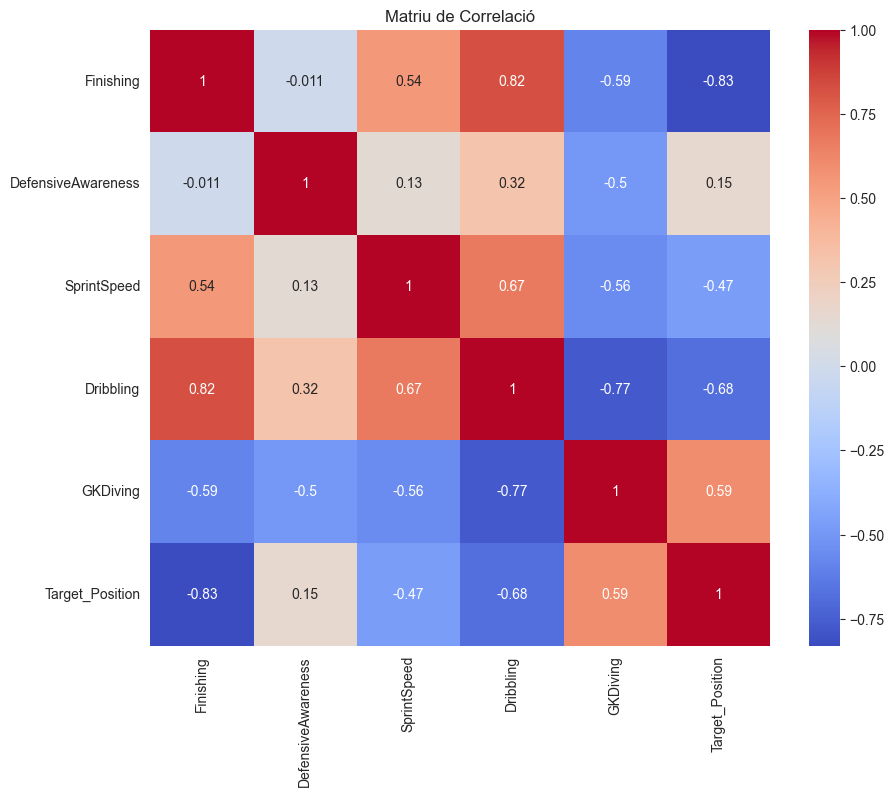

In [7]:
# Seleccionem només unes poques característiques clau per visualitzar
# Això ajuda a entendre què diferencia un davanter d'un defensa
features_of_interest = ['Finishing', 'DefensiveAwareness', 'SprintSpeed', 'Dribbling', 'GKDiving', 'Target_Position']

plt.figure(figsize=(10, 8))
sns.heatmap(df[features_of_interest].corr(), annot=True, cmap='coolwarm')
plt.title("Matriu de Correlació")
plt.show()

## 6. Preprocessament per al Model (Scikit-Learn)

### 6.1 Escalat de dades
Molts algoritmes (com Regressió Logística o SVM) són sensibles a l'escala. Si el `Value` va de 0 a 100M i l'`Age` de 16 a 40, el model donarà massa importància al valor econòmic.
Emprarem `StandardScaler` (mitjana 0, desviació 1).

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Definim X (features) i y (target)
# Triem 4 característiques com demana l'enunciat
features = ['Finishing', 'DefensiveAwareness', 'SprintSpeed', 'GKDiving']
X = df[features]
y = df['Target_Position']

# 2. Separació Train/Test (Essencial per validar overfitting!)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 3. Escalat (Només aprenem l'escala del train, i l'apliquem al test)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Dades preparades.")

Dades preparades.


## 7. Entrenament i Avaluació de Models

Entrenarem tres models i compararem els seus resultats. A més detectarem si hi ha *overfitting*. L'*overfitting* és un problema comú en l'entrenament de models d'aprenentatge automàtic. Per detectar l'*overfitting*, es pot utilitzar una estratègia simple:

- **Comparació de mètriques d'entrenament i validació**: Si la mètrica d'interès del problema en el conjunt d'entrenament és molt millor que en el conjunt de validació, és probable que el model tengui *overfitting*.

Si l'anterior no es comprova no es pot afirmar que hi hagi *overfitting*.

In [9]:
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Inicialitzem models
models = {
    "Logistic Regression": LogisticRegression(multi_class='ovr', max_iter=1000),
    "Perceptron": Perceptron(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

for name, model in models.items():
    print(f"--- Entrenant {name} ---")
    # Entrenament
    model.fit(X_train_scaled, y_train)
    
    # Predicció
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    
    # Avaluació
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    
    print(f"Accuracy Train: {acc_train:.4f}")
    print(f"Accuracy Test:  {acc_test:.4f}")
    
    # Detecció d'Overfitting
    if acc_train - acc_test > 0.1:
        print("ALERTA: Possible Overfitting detectat!")
    
    print("\n")

--- Entrenant Logistic Regression ---
Accuracy Train: 0.7830
Accuracy Test:  0.7754


--- Entrenant Perceptron ---
Accuracy Train: 0.7452
Accuracy Test:  0.7441


--- Entrenant Random Forest ---


/Users/miquelmn/Desenvolupament/01 - Docencia/ia2025/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy Train: 0.9986
Accuracy Test:  0.7850
ALERTA: Possible Overfitting detectat!




### 7.1 Anàlisi d'errors
Mirem la matriu de confusió del Random Forest (habitualment el millor) per veure on s'equivoca.

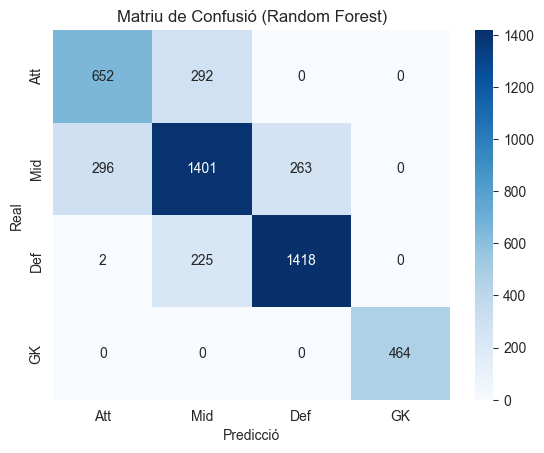

In [10]:
# Matriu de confusió pel Random Forest
rf_model = models["Random Forest"]
y_pred = rf_model.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Att', 'Mid', 'Def', 'GK'], 
            yticklabels=['Att', 'Mid', 'Def', 'GK'])
plt.ylabel('Real')
plt.xlabel('Predicció')
plt.title('Matriu de Confusió (Random Forest)')
plt.show()

In [12]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.69      0.69       944
           1       0.73      0.71      0.72      1960
           2       0.84      0.86      0.85      1645
           3       1.00      1.00      1.00       464

    accuracy                           0.78      5013
   macro avg       0.82      0.82      0.82      5013
weighted avg       0.78      0.78      0.78      5013



# **Feina a fer:**

1.  Prova de canviar les 4 característiques seleccionades a la secció 6. Millora el model si afegim `Dribbling` o `Passing`?
2.  Canvia els hiperparàmetres del `RandomForest` (ex: `max_depth`) i mira l'efecte que té al rendiment dels algoritmes.

## Annex: dades categòriques

Tenim dues estratègies possibles:

- **Substituir els valors per enters**
- **One hot encoding**


![OHE](https://www.statology.org/wp-content/uploads/2021/09/oneHot1.png)

In [8]:
clb = df.pop("Club")
ohe_clb = pd.get_dummies(clb, prefix='clb')
df = pd.concat([df.reset_index(drop=True), ohe_clb.reset_index(drop=True)], axis=1, sort=False)

df.head()

,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club Logo,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Best Position,Best Overall Rating,Release Clause,DefensiveAwareness,clb_1. FC Heidenheim 1846,clb_1. FC Kaiserslautern,clb_1. FC Köln,clb_1. FC Magdeburg,clb_1. FC Nürnberg,clb_1. FC Saarbrücken,clb_1. FC Union Berlin,clb_1. FSV Mainz 05,clb_111648,clb_12 de Octubre FC,clb_AC Ajaccio,clb_AC Horsens,clb_AC Milan,clb_AC Mineros de Guayana,clb_AC Monza,clb_AC Sparta Praha,clb_AD Alcorcón,clb_ADO Den Haag,clb_AEK Athens,clb_AFC Astra Giurgiu,clb_AFC Bournemouth,clb_AFC Chindia Târgoviște,clb_AFC Hermannstadt,clb_AFC UTA Arad,clb_AFC Wimbledon,clb_AIK,clb_AJ Auxerre,clb_APOEL Nicosia FC,clb_AS Monaco,clb_AS Nancy Lorraine,clb_AS Saint-Étienne,clb_ATK Mohun Bagan FC,clb_AZ Alkmaar,clb_Aalborg BK,clb_Aalesunds FK,clb_Aarhus GF,clb_Aberdeen,clb_Abha Club,clb_Academia Puerto Cabello,clb_Accrington Stanley,clb_Adana Demirspor,clb_Adelaide United,clb_Ajax,clb_Akhisar Belediyespor,clb_Al Ahli,clb_Al Ain,clb_Al Ain FC,clb_Al Batin,clb_Al Faisaly,clb_Al Fateh,clb_Al Fayha,clb_Al Hazem,clb_Al Hilal,clb_Al Ittihad,clb_Al Nassr,clb_Al Qadisiyah,clb_Al Raed,clb_Al Shabab,clb_Al Taawoun,clb_Al Tai,clb_Al Wehda,clb_Albacete BP,clb_Albirex Niigata,clb_Alianza Petrolera,clb_Altay SK,clb_Amiens SC,clb_América de Cali,clb_Angers SCO,clb_Antalyaspor,clb_Aragua Fútbol Club,clb_Arezzo,clb_Argentinos Juniors,clb_Arka Gdynia,clb_Arsenal,clb_Arsenal Tula,clb_Arsenal de Sarandí,clb_Ascoli,clb_Associação Chapecoense de Futebol,clb_Aston Villa,clb_Atakaş Hatayspor,clb_Atalanta,clb_Athletic Club de Bilbao,clb_Atlanta United,clb_Atlético Clube Goianiense,clb_Atlético Huila,clb_Atlético Nacional,clb_Atlético Tucumán,clb_Atlético de Madrid,clb_Audax Italiano,clb_Austin FC,clb_Avispa Fukuoka,clb_Aytemiz Alanyaspor,clb_BB Erzurumspor,clb_BK Häcken,clb_BSC Young Boys,clb_Bahia,clb_Barcelona Sporting Club,clb_Bari,clb_Barnet,clb_Barnsley,clb_Barrow,clb_Bayer 04 Leverkusen,clb_Beijing Guoan FC,clb_Beijing Renhe FC,clb_Belenenses SAD,clb_Benevento,clb_Bengaluru FC,clb_Beşiktaş JK,clb_Birmingham City,clb_Blackburn Rovers,clb_Blackpool,clb_Boavista FC,clb_Boca Juniors,clb_Bohemian FC,clb_Bologna,clb_Bolton Wanderers,clb_Borussia Dortmund,clb_Borussia Dortmund II,clb_Borussia Mönchengladbach,clb_Botafogo,clb_Bradford City,clb_Brentford,clb_Brescia,clb_Brighton & Hove Albion,clb_Brisbane Roar,clb_Bristol City,clb_Bristol Rovers,clb_Bruk-Bet Termalica Nieciecza,clb_Brøndby IF,clb_Bucaspor,clb_Burgos CF,clb_Burnley,clb_Bursaspor,clb_Burton Albion,clb_Bury,clb_Busan IPark,clb_C.D. Castellón,clb_CA Osasuna,clb_CD Antofagasta,clb_CD Everton de Viña del Mar,clb_CD Feirense,clb_CD Huachipato,clb_CD Leganés,clb_CD Lugo,clb_CD Mirandés,clb_CD Nacional,clb_CD Numancia,clb_CD O'Higgins,clb_CD Tenerife,clb_CD Tondela,clb_CD Universidad de Concepción,clb_CE Sabadell FC,clb_CF Fuenlabrada,clb_CF Monterrey,clb_CF Rayo Majadahonda,clb_CFR Cluj,clb_CS Emelec,clb_CS Mioveni,clb_CSM Politehnica Iași,clb_Cagliari,clb_Cambridge United,clb_Campionii FC Arges,clb_Cardiff City,clb_Carlisle United,clb_Carlos A. Mannucci,clb_Carpi,clb_Castellammare di Stabia,clb_Ceará Sporting Club,clb_Celtic,clb_Central Coast Mariners,clb_Centro Atlético Fénix,clb_Cerezo Osaka,clb_Cerro Largo Fútbol Club,clb_Cesena,clb_Chamois Niortais Football Club,clb_Changchun Yatai FC,clb_Charlton Athletic,clb_Chelsea,clb_Cheltenham Town,clb_Chennaiyin FC,clb_Chesterfield,clb_Chicago Fire Football Club,clb_Chievo Verona,clb_Cho